# __Scenario D:__<br>Time-dependent enzyme inactivation

Data provided by Paulo Durão (Microbial & Enzyme Technology, Instituto de Tecnologia Química e Biológica, Oeiras, Portugal)

## Project background
All investigated enzyme reactions without inhibitor applied to the reaction showed progress curve behavior, which was not explainable by irreversible Michaelis-Menten kinetics. All experiments had in common, that enzyme reactions were carried out in 96-well polystyrene micro titer plates (MTP), whereas the change in substrate or product absorption was monitored photometrically.  
One hypothesis for the suspected enzyme inactivation was hydrophobic interaction between the enzyme and the MTP surface. Thereby, hydrophobic regions of the enzyme's surface might interact with the polystyrene reaction vessel, potentially preventing substrate access to the active site of the enzyme. Another hypothesis for the observed gradual activity decrease was inactivation which is linked to the catalytic activity, as observed in the previous scenario.  

In order to test the hypothesis, an experiment was designed which detaches enzyme inactivation from enzyme activity. Therefore, enzyme was incubated in MTP wells prior to reaction start for different periods. Thereby, the enzyme activity should decrease depending on prior incubation time. If inactivation is independent from catalysis, the calculated half life from the adsorption experiment should match the half life of an enzyme kinetics experiment which was conducted in parallel and also considered an inactivation term.

### Experimental design

__Determination of enzyme inactivation through adsorption__  
The inactivation experiment was conducted by incubating CotA laccase from *Bacillus subtilis* in individual MTP wells up to 1 h prior to reaction start. Then, enzyme reactions were started in 10 min intervals by transferring 2 µL of incubated enzyme to individual MTP wells. Each proceeding enzyme reaction contained 256 nM CotA, 1 mM ABTS and was buffered in acetate buffer at pH 4. Product formation was followed photometrically at 420 nm and 25°C for 5 min, whereas concentrations were calculated assuming an extinction coefficient of ε = 36000 M<sup>-1</sup>cm<sup>-1</sup> for the ABTS radical product. Each experiment was performed as technical triplicates.

__Enzyme kinetics experiment__  
Enzymatic oxidation of ABTS to its radical form was followed photometrically at 420 nm at 25°C for 70 min. 
Thereby, ABTS was applied in a range from 0.01 mM - 2 mM. Each proceeding enzyme reaction contained 256 nM CotA, and was buffered in acetate buffer at pH 4. Each experimental condition was repeated as technical quadruplicates. Concentrations were calculated via the provided extinction coefficient of the ABTS radical.

### Experimental data

Measurement data was provided as an Excel file, containing time-course absorption data. Meta data was written into the EnzymeML Excel template. Then, the experimental data was written to an EnzymeML document by a parser function.

## Adsorption of enzyme to micro titer plate surface

### Imports

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
import pyenzyme as pe
from EnzymePynetics.tools.parameterestimator import ParameterEstimator
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import display
import string
from parser_functions import add_enzyme_inactivation_model

import warnings
warnings.filterwarnings('ignore')

### Calculation of inactivation rate
Experimental data was loaded into a Pandas DataFrame and the slopes of each incubation condition were calculated through linear regression. The resulting initial rates were then used to calculate the rate by which the enzyme activity decreases, when subjected to the reaction vessel.

Calculated time after enzyme activity is halved based on linear regression: 105.09 min


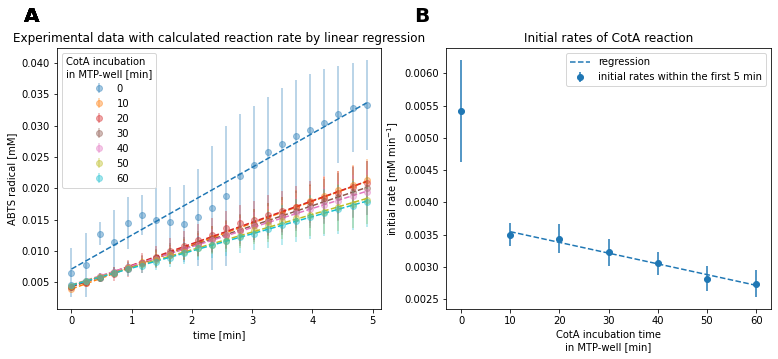

In [9]:
# Load excel
path = '../../data/enzyme_inactivation/Slide 2 - Activity effect of incubating CotA in MTP.xlsx'
df = pd.read_excel(path, sheet_name='csv').set_index('time (min)')

# replace values of '0**' with nan-values, since the measurement is incorrect
df['0**'] = np.nan

# Get data from Excel file
columns = [int(x) for x in list(df.columns) if str(x).endswith("0")]
time = df.index.values
absorption = df.values.T.reshape(7,3,22)

# Calculate concentrations
extinction_coefficient = 36 # (1/mM * 1/cm)
optical_length = 0.65 # cm

def absorption_to_concentration(abso):
    return abso / (extinction_coefficient*optical_length)

concentration = absorption_to_concentration(absorption)
concentration_mean = np.nanmean(concentration, axis = 1)
concentration_std = np.nanstd(concentration, axis = 1)

# Linear regression
slopes = []
intercepts = []
stderrs = []
for time_set in concentration:
    mask = ~np.isnan(time_set)
    time_regression = np.tile(time, 3).reshape(mask.shape)[mask].flatten()
    data_regression = time_set[mask].flatten()
    slope,intercept,_,_,stderr = (linregress(time_regression, data_regression))
    slopes.append(slope)
    intercepts.append(intercept)
    stderrs.append(stderr)

# Regression of the slopes between 10 and 60 min
slope_of_slopes, intercept_of_slopes,_,_,_ = linregress(columns[1:], slopes[1:])

# Calculate time at which enzyme activity is reduced by half
half_activity = ((slopes[1]/2 - slopes[1]) / slope_of_slopes)

# Plot results
print(f"Calculated time after enzyme activity is halved based on linear regression: {half_activity:.2f} min")

colors = cm.tab10(np.linspace(0, 1, len(absorption)))
fig, axes = plt.subplots(1,2, figsize=(12.8,4.8), sharey=False, sharex=False)

for mean, std, label, slope, intercept, color in zip(concentration_mean, concentration_std, columns, slopes, intercepts, colors):
    axes[0].errorbar(time, mean, std, fmt='o', label=label, alpha = 0.4, color=color)
    axes[0].plot(np.array(time), np.array(time)*slope+intercept, '--', color=color)
    axes[0].legend(title="CotA incubation\nin MTP-well [min]")
    axes[0].set_ylabel('ABTS radical [mM]')
    axes[0].set_xlabel('time [min]')
    axes[0].set_title('Experimental data with calculated reaction rate by linear regression')
    axes[0].text(-0.1, 1.1, string.ascii_uppercase[0], transform=axes[0].transAxes, 
            size=20, weight='bold')


axes[1].errorbar(columns, slopes, stderrs, fmt='o', label="initial rates within the first 5 min")
axes[1].set_xlabel("CotA incubation time\nin MTP-well [min]")
axes[1].set_ylabel('initial rate [mM min$^{-1}$]')
axes[1].plot(np.array(columns[1:]), slope_of_slopes*np.array(columns[1:])+intercept_of_slopes, "--", color=colors[0], label=f"regression")
axes[1].legend()
axes[1].set_title('Initial rates of CotA reaction')
axes[1].text(1.1, 1.1, string.ascii_uppercase[1], transform=axes[0].transAxes, 
        size=20, weight='bold')

plt.show()


_Fig. 14: Experimental data and regression results of CotA reaction with different enzyme incubation times._

Enzyme reactions without prior incubation showed the fastest reaction rate, whereas all reactions with prior incubation showed an approximately halved reaction rate (Fig. 14A). Thereby, reactions with longer incubation time showed gradually reduced reaction rates with increased incubation time. Enzyme reactions without incubation showed large deviations across all replicates. This presumably resulted from inhomogeneous mixing or deviating enzyme concentration due to the small volume of enzyme solution, which was used to start the reactions.  
Since the true reaction rate of reactions without prior incubation was highly uncertain and showed mixing issues, the respective data was not used to estimate the enzyme's inactivation rate.
Based on linear regression of the initial reaction rates, excluding the reaction without prior incubation, the enzyme activity is approximately halved after 105 min (Fig. 14B). This assumes validity of extrapolation.

## Enzyme kinetics experiment

### Experimental data 

Experimental data was provided as an Excel file, whereas meta data of the experiment was filled into an EnzymeML Excel spreadsheet. Measurement data was written to the EnzymeML document by a parser function.
Kinetic parameters were estimated with and without considering enzyme inactivation.


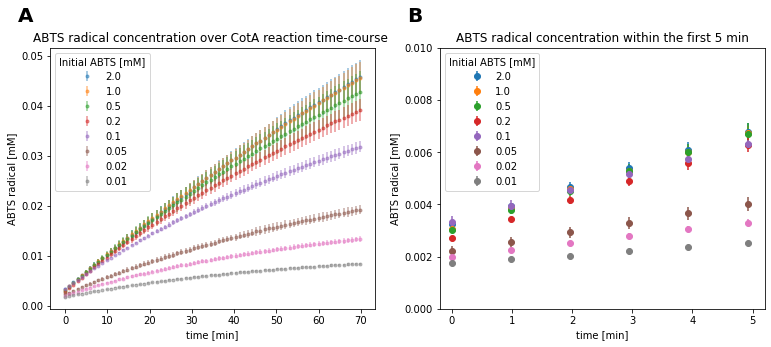

In [ ]:
# Load experimental data from excel file
df = pd.read_excel("../../data/enzyme_inactivation/Repetition CotA ABTS kinetics higher volumes 2nd time.xlsx", sheet_name="csv").set_index("Time(min)")
data = df.values.T.reshape(8,4,72)
time = df.index.values

# Calculate concentrations
extinction_coefficient = 36 # (1/mM * 1/cm)
optical_length = 0.65 # cm

def absorption_to_concentration(abso):
    return abso / (extinction_coefficient*optical_length)

concentration_data = absorption_to_concentration(data)

# Parser function
def data_to_EnzymeML(
    template_path: str,
    measurement_data: np.ndarray,
    species_id: str,
    data_unit: str,
    time_unit: str
    ) -> pe.EnzymeMLDocument:

    enzmldoc = pe.EnzymeMLDocument.fromTemplate(template_path)
    for IDs, concentration in zip(enzmldoc.measurement_dict.keys(), measurement_data):
        for counter, replicate in enumerate(concentration):
            rep = pe.Replicate(
                id=f"Measurement{counter}",
                species_id=species_id,
                data=list(replicate),
                data_unit=data_unit,
                time=list(time),
                time_unit=time_unit)
            enzmldoc.getMeasurement(IDs).addReplicates(rep, enzmldoc)
    return enzmldoc

# Write experimantal data to EnzymeML document vis parser function
enzmldoc = data_to_EnzymeML(
    template_path="../../data/enzyme_inactivation/EnzymeML_CotA.xlsm",
    measurement_data=concentration_data,
    species_id="s1",
    data_unit="mmole / l",
    time_unit="min")

# Visualize experimantal data
fig, axes = plt.subplots(1,2, figsize=(12.8, 4.8), sharey=False, sharex=False)
for measurement in enzmldoc.measurement_dict.values():
    concentration = []
    product = measurement.getReactant("s1")
    init_substrate=measurement.getReactant("s0").init_conc
    for replicate in product.replicates:
        concentration.append(replicate.data)
    axes[0].errorbar(time, np.mean(concentration, axis=0), np.std(concentration, axis=0), label=init_substrate,\
        fmt=".", alpha=0.5)
    axes[1].errorbar(time, np.mean(concentration, axis=0), np.std(concentration, axis=0), label=init_substrate,\
        fmt="o")

axes[0].legend(title="Initial ABTS [mM]")
axes[1].legend(title="Initial ABTS [mM]")
axes[0].set_ylabel("ABTS radical [mM]")
axes[0].set_title("ABTS radical concentration over CotA reaction time-course ")
axes[1].set_title("ABTS radical concentration within the first 5 min")
axes[1].set_ylabel("ABTS radical [mM]")
axes[0].set_xlabel("time [min]")
axes[1].set_xlabel("time [min]")
axes[1].set_xlim([-0.2,5.2])
axes[1].set_ylim([0,0.01])
axes[0].text(-0.1, 1.1, string.ascii_uppercase[0], transform=axes[0].transAxes, 
        size=20, weight='bold')
axes[1].text(1.1, 1.1, string.ascii_uppercase[1], transform=axes[0].transAxes, 
        size=20, weight='bold')

fig.show()


_Fig 15. ABTS radical concentration over the time-course of CotA reaction._

The provided reaction data showed large deviations between individual repeats of reactions with identical initial ABTS concentrations. Especially for initial ABTS concentrations above 0.1 mM (Fig. 15A).
Furthermore, visual analysis of the initial measurement points indicated that reactions with an initial substrate concentration of 0.1 mM had an increased enzyme concentration compared to others. This is evident, because the mentioned reactions show the highest concentration at the initial measurement time (Fig. 15B). The order of initial measurement points is expected to reflect the initial substrate concentrations, since the substrate slightly absorbs at the product detection wavelength. The substrate of the mentioned reaction was likely applied correctly, since the final concentration at 70 min is between reactions with the next lower and next higher initial substrate concentration.

## Kinetic parameter estimation

### Quality control through modeling
An initial parameter estimation considering enzyme inactivation was conducted in order to check further systematic deviations. As a result, reactions with an initial ABTS concentration of 0.05 mM showed to deviate from all other reactions, since the product concentrations was lower than the model predicted. The mentioned measurements were the only ones where the measured concentration was distinctly and systematically below that of the model (Fig. 16A). Hence indicating, that either less substrate or enzyme than defined in the protocol was applied to the respective reactions. In consequence, data from reactions with an initial substrate concentration of 0.05 and 0.1 mM were excluded from parameter estimation, because the identified systematic deviations in reaction conditions would distort the results.

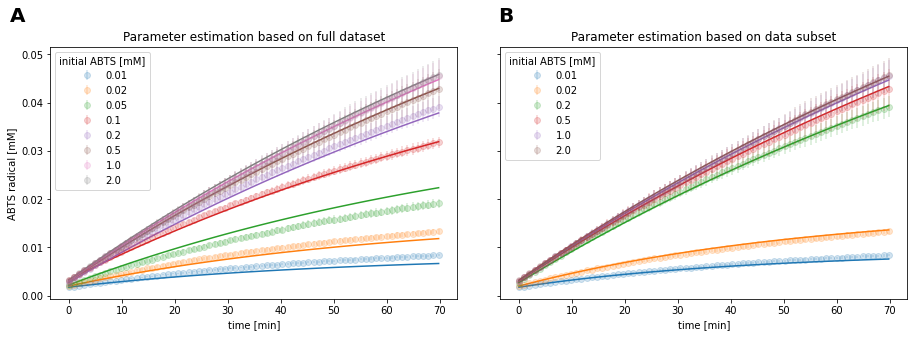

In [ ]:
# Parameter estimation considering time-dependent enzyme inactivation
CotA_kinetics_first_run = ParameterEstimator.from_EnzymeML(enzmldoc, "s1", "product")
CotA_kinetics_first_run.fit_models(enzyme_inactivation=True, display_output=False, initial_substrate_concs=[0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0])

# Parameter estimation considering time-dependent enzyme inactivation
CotA_kinetics_with_inactivation = ParameterEstimator.from_EnzymeML(enzmldoc, "s1", "product")
CotA_kinetics_with_inactivation.fit_models(enzyme_inactivation=True, display_output=False, initial_substrate_concs=[0.01, 0.02, 0.2, 0.5, 1.0, 2.0])
df_inactivation = CotA_kinetics_with_inactivation.result_dict.drop(columns=["kcat / Km [1/min * 1/mmole / l]"])
df_inactivation.insert(1, "Enzyme inactivation model", "True")

# Visualize fit of the models
fig, axes = plt.subplots(1,2, figsize=(12.8,4.8), sharey=True, sharex=True)
CotA_kinetics_first_run.visualize("irreversible Michaelis Menten",ax=axes[0], alpha =.2,\
    title="Parameter estimation based on full dataset")
CotA_kinetics_with_inactivation.visualize("irreversible Michaelis Menten",ax=axes[1], alpha =.2,\
    title="Parameter estimation based on data subset")

axes[0].set_ylabel("ABTS radical [mM]")
axes[0].set_xlabel("time [min]")
axes[1].set_xlabel("time [min]")
axes[0].legend(title="initial ABTS [mM]")
axes[1].legend(title="initial ABTS [mM]")
axes[0].text(-0.1, 1.1, string.ascii_uppercase[0], transform=axes[0].transAxes, 
        size=20, weight='bold')
axes[1].text(1.1, 1.1, string.ascii_uppercase[1], transform=axes[0].transAxes, 
        size=20, weight='bold')
plt.tight_layout()

_Fig 16: Identification of systematic deviations through kinetic modeling._

By excluding the mentioned measurements with systematic issues, the model fit was improved (Fig 16B). Additionally, the correlation between parameter estimates for $k_{cat}$ and $K_{m}$ was reduced from *r<sup>2</sup>* = 0.518 to 0.204.
### Parameter estimation with and without considering enzyme inactivation


In [ ]:
# Parameter estimation without time-dependent enzyme inactivation
CotA_kinetics = ParameterEstimator.from_EnzymeML(enzmldoc, "s1", "product")
CotA_kinetics.fit_models(enzyme_inactivation=False, display_output=False, initial_substrate_concs=[0.01, 0.02, 0.2, 0.5, 1.0, 2.0])
df = CotA_kinetics.result_dict.drop(columns=["kcat / Km [1/min * 1/mmole / l]"])
df.insert(1, "Enzyme inactivation model", "False")

results = df.append(df_inactivation).sort_values("AIC")
display(results.style.set_table_attributes('style="font-size: 12px"'))

,AIC,Enzyme inactivation model,kcat [1/min],Km [mmole / l],Ki competitive [mmole / l],Ki uncompetitive [mmole / l],ki time-dep enzyme-inactiv. [1/min]
irreversible Michaelis Menten,-22202,True,3.003 +/- 0.77%,0.030 +/- 1.99%,-,-,0.007 +/- 4.48%
competitive product inhibition,-22202,True,2.999 +/- 0.78%,0.029 +/- 3.85%,0.221 +/- 92.18%,-,0.007 +/- 5.06%
substrate inhibition,-22202,True,3.021 +/- 0.86%,0.031 +/- 2.38%,-,208.577 +/- 67.12%,0.007 +/- 4.48%
uncompetitive product inhibition,-22199,True,3.012 +/- 1.23%,0.030 +/- 4.72%,-,2.096 +/- 361.49%,0.006 +/- 15.30%
non-competitive product inhibition,-22198,True,3.012 +/- 2.44%,0.029 +/- 6.56%,0.167 +/- 132.63%,1.113 +/- 466.95%,0.006 +/- 40.69%
non-competitive product inhibition,-22185,False,3.241 +/- 1.40%,0.033 +/- 5.05%,0.038 +/- 22.41%,0.073 +/- 6.86%,nan
uncompetitive product inhibition,-22156,False,3.268 +/- 1.43%,0.041 +/- 2.70%,-,0.066 +/- 6.35%,nan
competitive product inhibition,-21840,False,2.586 +/- 0.35%,0.020 +/- 6.10%,0.016 +/- 15.88%,-,nan
irreversible Michaelis Menten,-21739,False,2.529 +/- 0.27%,0.030 +/- 2.30%,-,-,nan
substrate inhibition,-21737,False,2.537 +/- 0.52%,0.030 +/- 2.71%,-,352.069 +/- 134.63%,nan


Kinetic parameters were estimated with and without considering time-dependent enzyme inactivation. 
Modeling results are listed in the table above.
All models with an additional parameter for enzyme inactivation resulted in lower AIC values, indicating a better fit of the experimental data to inactivation models.  
When comparing models, an additional parameter in a model is informative, if the difference in AIC between the two models is larger than 2 . Accordingly, two additional parameters in a model compared to another model are informative, if the difference in AIC is larger than 4 {cite}`arnold2010uninformative`. Thus, the additional parameters in inhibition models considering enzyme activation were uninformative and did not enhance the fit quality. Additionally, the mentioned models showed high standard deviations above 80% for the respective $K_{i}$ estimates. 
Without considering enzyme inactivation, product inhibition models were favoured over the irreversible Michaelis-Menten model, 
whereas irreversible Michaelis-Menten with enzyme inactivation showed the best fit statistic compared to all other models (Fig 17A). Thereby, $k_{cat}$ was estimated to 3.003 min<sup>-1</sup> ± 0.77% whereas 30 µM ± 1.99%  was estimated for $K_{m}$. The respective half life of CotA was estimated at 95 min ± 4 min using equation [](enzyme_halflife), whereas $k_{cat}$ and $k_{inact}$ were highly correlated (*r<sup>2</sup>* > 0.95). Irreversible Michelis-Menten model without enzyme concentration did not fit the measurement data, since the reaction rate is initially underestimated, and overestimated in later stages of the reaction (Fig 17B).  

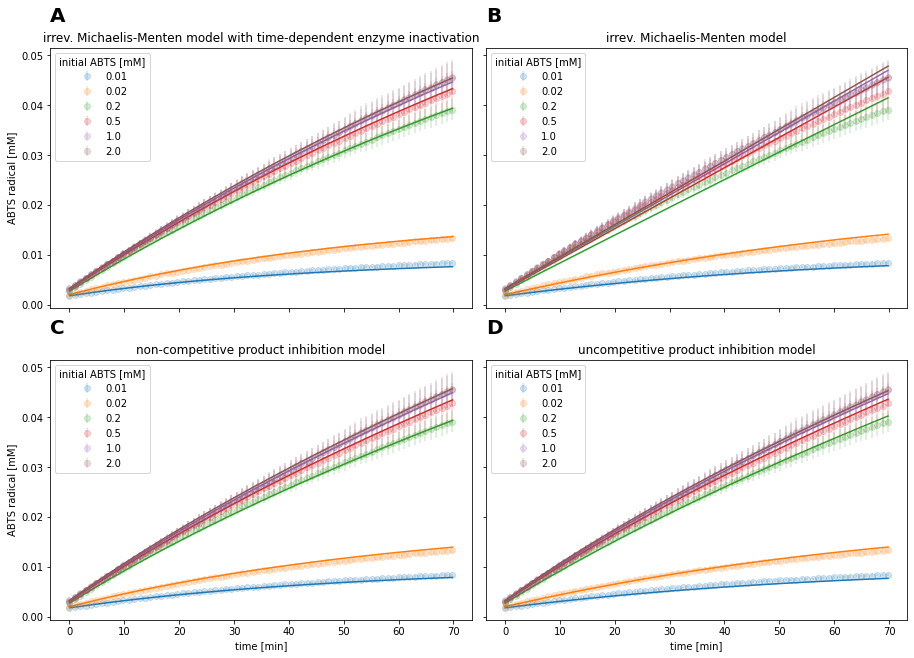

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(12.8,9.2), sharey=True, sharex=True)
CotA_kinetics_with_inactivation.visualize("irreversible Michaelis Menten",ax=axes[0][0], alpha =.2,\
    title="irrev. Michaelis-Menten model with time-dependent enzyme inactivation")
CotA_kinetics.visualize("irreversible Michaelis Menten",ax=axes[0][1], alpha =.2,\
    title="irrev. Michaelis-Menten model")
CotA_kinetics.visualize("non-competitive product inhibition",ax=axes[1][0], alpha =.2,\
    title="non-competitive product inhibition model")
CotA_kinetics.visualize("uncompetitive product inhibition",ax=axes[1][1], alpha =.2,\
    title="uncompetitive product inhibition model")

axes[0][0].set_ylabel("ABTS radical [mM]")
axes[1][0].set_ylabel("ABTS radical [mM]")
axes[1][0].set_xlabel("time [min]")
axes[1][1].set_xlabel("time [min]")
[ax.legend(title="initial ABTS [mM]") for ax in axes.flatten()]

[ax.text(0, 1.1, string.ascii_uppercase[i], transform=ax.transAxes, size=20, weight='bold') for i, ax in enumerate(axes.flatten())]

# axes[0]
# axes[1].text(1.1, 1.1, string.ascii_uppercase[1], transform=axes[0].transAxes, 
#         size=20, weight='bold')
plt.tight_layout()

_Fig. 17: Different kinetic models fitted to CotA reaction data_

Out of the models without enzyme inactivation, product inhibition models showed the lowest AIC. Qualitatively, the inhibition models  described the progress curve of the reaction (Fig. 17C and 17D) similarly to the best fitting model (Fig. 17A)

## Project discussion

### Data quality
Both datasets, for the absorption experiment and the enzyme kinetics experiment, showed quality issues. In the adsorption experiment the initial measurement showed large uncertainties as well as mixing issues, indicated by an apparent fluctuation in reaction rate. In the enzyme kinetics experiment, individual reactions were shown to have substrate and enzyme concentrations that deviated from the assay protocol. Furthermore, the measured product concentration showed large deviations among experimental repeats, indicating unequal enzyme concentrations. Hence, larger pipetting volume for the enzyme solution was suggested to reduce pipetting errors. 
Furthermore, the project partners were advised to repeat the experiments.

### Enzyme inactivation 
The observed time-dependent decrease in enzyme activity can be explained by enzyme inactivation and product inhibition. In the case of time-dependent enzyme inactivation, the catalytic activity decreases, since the catalyst becomes inactive. Thereby, the decrease in relative reaction rate is independent from product concentration.
In the case of product inhibition, the formed product reduces the reaction rate. Hence, the observed enzyme inactivation is dependent on product concentration.
Since both phenomena express themselves in an apparent decrease of reaction rate, they bare the potential to be confused, as the results of the enzyme kinetics experiment show. Visually, product inhibition models without enzyme inactivation and irreversible Michaelis-Menten model with enzyme inactivation are able to qualitatively describe the observed progress curve (Fig 17C, 17D). 

Both independent and methodologically different experiments resulted in a comparable time period, in which the enzyme's activity is halved. Whereas in the inactivation experiment the enzyme's activity was halved after approximately 105 min, half the activity was left in the enzyme kinetics experiment after 95 min. Due to the design of the incubation experiment, the loss of enzyme activity showed to be independent from the catalysis itself. In consequence, product inhibition is not a conclusive explanation for the observed behavior. Product inhibition is further disfavored based on the modeling results, since the AIC of all inhibition models was higher compared the irreversible Michaelis-Menten model with time-dependent enzyme inactivation.

In conclusion, the observed inactivation in potentially caused by hydrophobic interaction between the reaction vessel and the enzyme. Interactions between hydrophobic surfaces and enzymes leading to decreased enzymatic activity were already reported for ribonuclease A {cite}`wei2014adsorption`. In this work, enzyme inactivation was observed across multiple enzyme classes, where all reactions were carried out in MTPs. Therefore, MTPs might cause enzyme inactivation for a broad range of different enzymes.

Misinterpretation of the apparent decrease in enzymatic activity might lead to wrong conclusions and therefore negatively impacts the research process. As already mentioned the activity decrease might be wrongfully attributed to product inhibition. This attribution might lead to wrong design decisions if the enzyme in question should be applied to an enzymatic cascade reaction or make the enzyme entirely unfavorable for this particular application.  
Furthermore, screening applications might be impacted by enzyme inactivation, if yields of an enzymatic reactions should be determined over the time course of multiple hours. In consequence, the determined time-dependent yield might be estimated too low.
Therefore, enzyme inactivation in MTPs should be investigated in future experiments and the results should be reported on.

## Save modeling results
Lastly, the modeling results were written to the EnzymeML documents and the files were exported.

In [ ]:
# Write modeling results to kinetic parameters
k_cat = pe.enzymeml.models.KineticParameter(
    name="k_cat",
    value=CotA_kinetics_with_inactivation.get_model_results()["k_cat"].value,
    unit=f"1 / {CotA_kinetics_with_inactivation.data.time_unit}")

K_m = pe.enzymeml.models.KineticParameter(
    name="K_m",
    value=CotA_kinetics_with_inactivation.get_model_results()["Km"].value,
    unit=CotA_kinetics_with_inactivation.data.data_conc_unit)

# Define kinetic model
model = pe.KineticModel(
    name="irreversible Michaelis-Menten",
    equation="-k_cat * p0 * s0 / (K_m + s0)",
    parameters=[k_cat, K_m])

enzmldoc.getReaction("r0").model = model

add_enzyme_inactivation_model(
    result=CotA_kinetics_with_inactivation,
    enzmldoc=enzmldoc)

# Export EnzymeML documents
export = False
if export:
    enzmldoc.toFile()